# Maximum Likelihood Estimation

Authors: Audrey Olivier, Dimitris G. Giovanis <br>
Last modified on 10/7/2019 by Audrey Olivier

This notebook illustrates the use of the Model class to create a model for inference, and the MLEstimation class to perform maximum likelihood estimation of the parameters of that model. Recall that a maximum likelihood estimate is simply the parameter vector that maximizes the likelihood:

$$ \theta_{ML} = argmax_{\Theta} \left[ p(data \vert \theta) \right] $$

In particular, the following models are studied:
- a probability model with an existing fit method,
- a probability model without a fit method (custom distribution, or distribution with copulas),
- a python model defined with RunModel.

## Probability distribution model with an existing fit method

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from UQpy.Inference import InferenceModel, MLEstimation
from UQpy.Distributions import Distribution

Shape of data vector: (1000, 1)


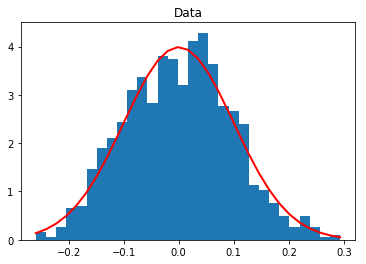

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data_1 = np.random.normal(mu, sigma, 1000).reshape((-1,1))
print('Shape of data vector: {}'.format(data_1.shape))

count, bins, ignored = plt.hist(data_1, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title('Data')
plt.show()

Create an instance of the class Model. The user must define the number of parameters to be estimated, in this case 2 (mean and standard deviation). For maximum likelihood estimation, no prior pdf is required.

In [3]:
candidate_model = InferenceModel(nparams=2, distribution_object=Distribution('normal'))

Perform maximum likelihood. Setting verbose=True, some comments are written and one can see that the maximul likelihood procedure uses the fit method of the probability distribution.

In [4]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_1, verbose=True, method='nelder-mead',
                            iter_optim=1)
print('ML estimates of the mean={0:.3f} (true=0.) and std. dev={1:.3f} (true=0.1)'.format(
    ml_estimator.mle[0], ml_estimator.mle[1]))

Initialization of MLEstimation object completed.
Evaluating maximum likelihood estimate for inference model , using fit method.
ML estimation completed.
ML estimates of the mean=-0.000 (true=0.) and std. dev=0.097 (true=0.1)


## Probability model for which the fit method is not defined.

Here we define a bivariate probability model, with a dependence structure defined using a gumbel copula. The goal of inference is to learn the paremeters of the Gaussian marginals and the copula parameter, i.e., the model has 5 unknown parameters. 

First data is generated from a true model. A distribution with copulas does not possess a fit method, thus sampling is performed using importance sampling/resampling.

Shape of data: (5000, 2)


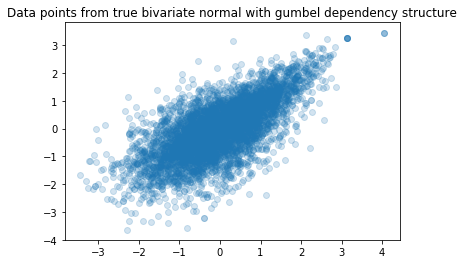

In [5]:
# dist_true exhibits dependence between the two dimensions, defined using a gumbel copula
dist_true = Distribution(dist_name=['normal', 'normal'], copula='gumbel')
params_dist = [[0, 1], [0, 1]]
params_copula = 2
dist_true.update_params(params=params_dist, copula_params=params_copula)

# generate data using importance sampling: sample from a bivariate gaussian without copula, then weight samples
from UQpy.SampleMethods import IS
u = IS(proposal=Distribution(['normal']*2, params=[[0, 1], [0, 1]]),
       log_pdf_target=dist_true.log_pdf, nsamples = 500000)
# Resample to obtain 5,000 data points
data_2 = u.resample(size=5000)
print('Shape of data: {}'.format(data_2.shape))

fig, ax = plt.subplots()
ax.scatter(data_2[:,0], data_2[:,1], alpha=0.2)
ax.set_title('Data points from true bivariate normal with gumbel dependency structure')
plt.show()

To define a model for inference, the user must create a custom file, here bivariate_normal_gumbel.py, to compute the log_pdf of the distribution, given a bivariate data matrix and a parameter vector of length 5. Note that for any probability model that is not one of the simple univariate pdfs supported by UQpy, such a custom file will be necessary.

In [6]:
candidate_model = InferenceModel(nparams=5, distribution_object=Distribution('bivariate_normal_gumbel'))

When calling MLEstimation for a distribution model without a fit, or a python model, the function minimize from the scipy.optimize package is used. The user can define bounds for the optimization, a seed, the algorithm to be used, and set the algorithm to perform several optimization iterations, starting at a different random seed every time.

In [7]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_2, verbose=True,
                            bounds=[[-5, 5], [0, 10], [-5, 5], [0, 10], [1.01, 4]], method='SLSQP')

Initialization of MLEstimation object completed.


In [8]:
ml_estimator.run_estimation(iter_optim=1)

print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 1st marginal (true: 0.0, 1.0)'.
      format(ml_estimator.mle[0], ml_estimator.mle[1]))
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f} of 2nd marginal (true: 0.0, 1.0)'.
      format(ml_estimator.mle[2], ml_estimator.mle[3]))
print('ML estimates of the copula parameter={0:.3f} (true: 2.0)'.format(ml_estimator.mle[4]))

Evaluating maximum likelihood estimate for inference model , via optimization.
ML estimation completed.
ML estimates of the mean=-0.016 and std. dev=1.014 of 1st marginal (true: 0.0, 1.0)
ML estimates of the mean=-0.018 and std. dev=1.027 of 2nd marginal (true: 0.0, 1.0)
ML estimates of the copula parameter=1.986 (true: 2.0)


## Regression model (model linear in the parameters)

Here a model is defined that is of the form 

$$y=f(\theta) + \epsilon$$

where f consists in running RunModel. In particular, here $f(\theta)=\theta_{0} x + \theta_{1} x^{2}$ is a regression model.

First we generate synthetic data, and add some noise to it.

In [9]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape((1, -1))
error_covariance = np.eye(50)

print('Shape of true parameter vector: {}'.format(param_true.shape))
from UQpy.RunModel import RunModel
h_func = RunModel(model_script='pfn_models.py', model_object_name='model_quadratic', var_names=['theta_0', 'theta_1'])
z = h_func.run(samples=param_true)
data_3 = h_func.qoi_list[0].reshape((-1,))+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print('Shape of data: {}'.format(data_3.shape))

Shape of true parameter vector: (1, 2)
Shape of data: (50,)


Then we create an instance of the Model class, using model_type='python', and we perform maximum likelihood estimation of the two parameters.

In [10]:
candidate_model = InferenceModel(nparams=2, run_model_object=h_func, error_covariance=error_covariance)

In [11]:
ml_estimator = MLEstimation(inference_model=candidate_model, data=data_3, method='nelder-mead', iter_optim=1)
print('fitted parameters: theta_0={0:.3f} (true=1.), and theta_1={1:.3f} (true=2.)'.format(
    ml_estimator.mle[0], ml_estimator.mle[1]))

fitted parameters: theta_0=0.945 (true=1.), and theta_1=2.005 (true=2.)
